In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix   

2023-05-22 05:14:54.812493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-22 05:14:54.812523: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")

In [3]:
def get_data_with_ratio(ratio):
    # Shuffle the data
    shuffled_data = shuffle(data, random_state=42)

    # Get unique classes from the "Peruntukan" column
    classes = shuffled_data['Peruntukan'].unique()

    # Initialize empty dataframes for train and test data
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Iterate over each class
    for cls in classes:
        cls_data = shuffled_data[shuffled_data['Peruntukan'] == cls]

        # Split the class data into train and test
        cls_train, cls_test = train_test_split(cls_data, test_size=ratio, random_state=42)

        # Append the train and test data to the respective dataframes
        train_data = train_data.append(cls_train)
        test_data = test_data.append(cls_test)
        
        training = train_data
        test = test_data

        training = training[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
        test = test[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]


    
    return training, test


# Data visualisasi

# Change categorical to number 

In [4]:
def change_categorical_to_number(data):
    
    data = data
    
 
    ####
    ####

    condition = [  data.Visibilitas == "Strategis",
                 data.Visibilitas == "Sedang",
                  data.Visibilitas == "Kurang",
    ]

    value = [3,2,1]

    data.Visibilitas = np.select(condition,value)
    #####
    #####

    condition = [  data.Bangunan == "Bagus",
                 data.Bangunan == "Sedang",

    ]

    value = [2,1]

    data.Bangunan = np.select(condition,value,0)


    condition = [ 
                data.Peruntukan == "Pasar",
                 data.Peruntukan == "Kantor",
                 data.Peruntukan == "Ruko",
                 data.Peruntukan == "Taman",
                 data.Peruntukan == "Perumahan",
                 data.Peruntukan == "Sawah",

    ]

    value = [5,4,3,2,1,0]

    data.Peruntukan = np.select(condition,value,0)
    
    return data

# Dataframe to Dataset

In [5]:
def df_to_dataset(dataframe, shuffle=False, batch_size=4):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# Feature Normalizer

In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
def encoded_features(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak pusat kota2","Visibilitas","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

In [8]:
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Model build

In [9]:
def model(encoded_features,all_inputs):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(6)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics="accuracy",
                 )
    
    return model

# History build

In [10]:
def history(model,callbacks,train_ds,val_ds):
    

    history = model.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=callbacks)

    # Get the training and validation metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = history.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    
    return history


# Evaluation the Model

In [11]:
def run_model(ratio,callbacks):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    
    encoded,inputs = encoded_features(train_ds)

    
    #set the model
    model_engine = model(encoded,inputs)
    
    #run and evaluate the model
    model_engine2 = history(model_engine,callbacks,train_ds,val_ds)
    
    #evaluate confusion matrix
    confussion_matrix(model_engine2,val_ds,test_2)

In [12]:
def confussion_matrix(best_model, val_ds,test_data):
    from sklearn.metrics import confusion_matrix   
    model =  best_model
    
    y_pred = model.model.predict(val_ds)

    # Ubah output prediksi menjadi label kelas
    label_kelas = [0, 1, 2, 3, 4, 5]
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    #test label
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)
    
    max_test_accuracy_index = model.history['val_accuracy'].index(max(model.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = model.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(model.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)


    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
    for label, accuracy in zip(label_kelas, class_accuracies):
        print("Accuracy for", label, ":", accuracy)
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_f1 = np.mean(f1_score)

    # Print the results
    print("Total Precision:", total_precision)
    print("Total Recall:", total_recall)
    print("Total F1 Score:", total_f1)

    # Print the results
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)
    print("F1 Score for each label:", f1_score)
    print("Total Accuracy:", total_accuracy)

# Model Evaluation

In [13]:
callback_1 = ModelCheckpoint("50.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_1 = 0.5

callback_2= ModelCheckpoint("40.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_2 = 0.4

callback_3= ModelCheckpoint("30.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_3 = 0.3

callback_4= ModelCheckpoint("20.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_4 = 0.2

callback_5= ModelCheckpoint("10.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_5 = 0.1

/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
13/13 [==============================] - 1s 20ms/step - loss: 1.7133 - accuracy: 0.2449 - val_loss: 1.6994 - val_accuracy: 0.2037
Epoch 2/150
13/13 [==============================] - 0s 7ms/step - loss: 1.6891 - accuracy: 0.2857 - val_loss: 1.6540 - val_accuracy: 0.2222
Epoch 3/150
13/13 [==============================] - 0s 7ms/step - loss: 1.5873 - accuracy: 0.3673 - val_loss: 1.6115 - val_accuracy: 0.2407
Epoch 4/150
13/13 [==============================] - 0s 5ms/step - loss: 1.5209 - accuracy: 0.4082 - val_loss: 1.5723 - val_accuracy: 0.2407
Epoch 5/150
13/13 [==============================] - 0s 6ms/step - loss: 1.4348 - accuracy: 0.4082 - val_loss: 1.5342 - val_accuracy: 0.3148
Epoch 6/150
13/13 [==============================] - 0s 7ms/step - loss: 1.3667 - accuracy: 0.4898 - val_loss: 1.4978 - val_accuracy: 0.4074
Epoch 7/150
13/13 [==============================] - 0s 7ms/step - loss: 1.5254 - accuracy: 0.3878 - val_loss: 1.4636 - val_accuracy: 0.4259
Epoch 8/150


Epoch 59/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8593 - accuracy: 0.6327 - val_loss: 0.7070 - val_accuracy: 0.7222
Epoch 60/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8011 - accuracy: 0.6531 - val_loss: 0.6995 - val_accuracy: 0.7222
Epoch 61/150
13/13 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.7755 - val_loss: 0.6922 - val_accuracy: 0.7222
Epoch 62/150
13/13 [==============================] - 0s 7ms/step - loss: 0.8551 - accuracy: 0.6327 - val_loss: 0.6853 - val_accuracy: 0.7407
Epoch 63/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8369 - accuracy: 0.7143 - val_loss: 0.6776 - val_accuracy: 0.7407
Epoch 64/150
13/13 [==============================] - 0s 4ms/step - loss: 0.7480 - accuracy: 0.6735 - val_loss: 0.6706 - val_accuracy: 0.7407
Epoch 65/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7174 - accuracy: 0.7347 - val_loss: 0.6639 - val_accuracy: 0.7407
Epoch 

13/13 [==============================] - 0s 5ms/step - loss: 0.5257 - accuracy: 0.8163 - val_loss: 0.4305 - val_accuracy: 0.9074
Epoch 117/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4908 - accuracy: 0.8571 - val_loss: 0.4303 - val_accuracy: 0.9074
Epoch 118/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4877 - accuracy: 0.8367 - val_loss: 0.4278 - val_accuracy: 0.9074
Epoch 119/150
13/13 [==============================] - 0s 4ms/step - loss: 0.5128 - accuracy: 0.8163 - val_loss: 0.4251 - val_accuracy: 0.9074
Epoch 120/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4914 - accuracy: 0.8367 - val_loss: 0.4212 - val_accuracy: 0.9074
Epoch 121/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4085 - accuracy: 0.8571 - val_loss: 0.4169 - val_accuracy: 0.9074
Epoch 122/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4502 - accuracy: 0.8367 - val_loss: 0.4112 - val_accuracy: 0.9074
Epoch 123/150

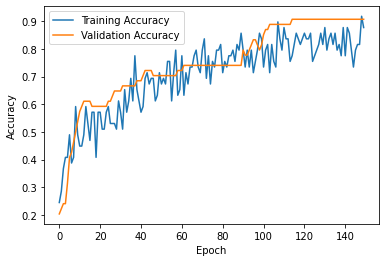

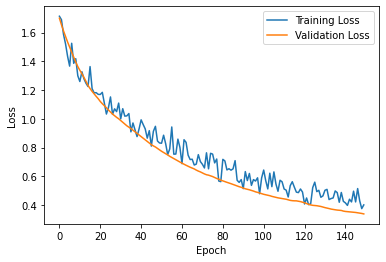

Best validation accuracy: 0.9074074029922485
Training accuracy at the best test accuracy: 0.7755101919174194
Best validation accuracy: 0.9074074029922485
Training accuracy at the best test accuracy: 0.7755101919174194
Confusion matrix:
[[12  0  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 0  0  3  0  0  0]
 [ 0  0  0 21  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  5  0  3]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 80.76923076923077
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.967948717948718
Total Recall: 0.8958333333333334
Total F1 Score: 0.9065119277885234
Accuracy for each label: [100.         100.         100.          80.76923077 100.
 100.        ]
Precision for each label: [1.         1.         1.         0.80769231 1.         1.        ]
Recall for each label: [1.    1.    1.    1.    1.    0.375]
F1 Score for each label: [1.         1.         1.         0.89361702 1.         0.54545455]
Total Accuracy: 90.74074074074075


In [14]:
run_model(ratio_1, callback_1)

/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
15/15 [==============================] - 1s 18ms/step - loss: 2.0691 - accuracy: 0.0500 - val_loss: 2.0931 - val_accuracy: 0.1395
Epoch 2/150
15/15 [==============================] - 0s 7ms/step - loss: 2.0751 - accuracy: 0.2167 - val_loss: 2.0112 - val_accuracy: 0.1628
Epoch 3/150
15/15 [==============================] - 0s 7ms/step - loss: 1.9848 - accuracy: 0.2000 - val_loss: 1.9375 - val_accuracy: 0.1860
Epoch 4/150
15/15 [==============================] - 0s 6ms/step - loss: 1.8693 - accuracy: 0.1833 - val_loss: 1.8695 - val_accuracy: 0.2093
Epoch 5/150
15/15 [==============================] - 0s 4ms/step - loss: 1.8603 - accuracy: 0.2000 - val_loss: 1.8049 - val_accuracy: 0.1860
Epoch 6/150
15/15 [==============================] - 0s 6ms/step - loss: 1.7797 - accuracy: 0.2333 - val_loss: 1.7507 - val_accuracy: 0.2791
Epoch 7/150
15/15 [==============================] - 0s 7ms/step - loss: 1.7647 - accuracy: 0.2667 - val_loss: 1.7003 - val_accuracy: 0.3488
Epoch 8/150


Epoch 59/150
15/15 [==============================] - 0s 4ms/step - loss: 0.7712 - accuracy: 0.7500 - val_loss: 0.6584 - val_accuracy: 0.7907
Epoch 60/150
15/15 [==============================] - 0s 4ms/step - loss: 0.7401 - accuracy: 0.8167 - val_loss: 0.6468 - val_accuracy: 0.7907
Epoch 61/150
15/15 [==============================] - 0s 4ms/step - loss: 0.7270 - accuracy: 0.7667 - val_loss: 0.6369 - val_accuracy: 0.7907
Epoch 62/150
15/15 [==============================] - 0s 4ms/step - loss: 0.7696 - accuracy: 0.7167 - val_loss: 0.6290 - val_accuracy: 0.7907
Epoch 63/150
15/15 [==============================] - 0s 4ms/step - loss: 0.7020 - accuracy: 0.7333 - val_loss: 0.6208 - val_accuracy: 0.7907
Epoch 64/150
15/15 [==============================] - 0s 4ms/step - loss: 0.7501 - accuracy: 0.7167 - val_loss: 0.6129 - val_accuracy: 0.7907
Epoch 65/150
15/15 [==============================] - 0s 4ms/step - loss: 0.7496 - accuracy: 0.6500 - val_loss: 0.6039 - val_accuracy: 0.7907
Epoch 

15/15 [==============================] - 0s 4ms/step - loss: 0.4874 - accuracy: 0.8167 - val_loss: 0.3619 - val_accuracy: 0.9070
Epoch 117/150
15/15 [==============================] - 0s 4ms/step - loss: 0.4586 - accuracy: 0.8833 - val_loss: 0.3596 - val_accuracy: 0.9070
Epoch 118/150
15/15 [==============================] - 0s 4ms/step - loss: 0.4749 - accuracy: 0.8500 - val_loss: 0.3579 - val_accuracy: 0.9070
Epoch 119/150
15/15 [==============================] - 0s 5ms/step - loss: 0.4307 - accuracy: 0.8500 - val_loss: 0.3553 - val_accuracy: 0.9070
Epoch 120/150
15/15 [==============================] - 0s 5ms/step - loss: 0.4264 - accuracy: 0.9000 - val_loss: 0.3527 - val_accuracy: 0.9070
Epoch 121/150
15/15 [==============================] - 0s 4ms/step - loss: 0.5012 - accuracy: 0.8333 - val_loss: 0.3510 - val_accuracy: 0.9070
Epoch 122/150
15/15 [==============================] - 0s 4ms/step - loss: 0.5486 - accuracy: 0.7833 - val_loss: 0.3482 - val_accuracy: 0.9070
Epoch 123/150

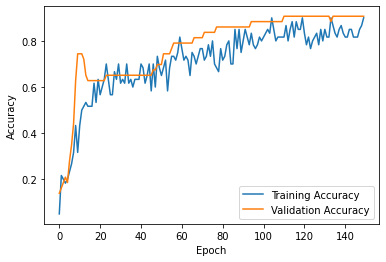

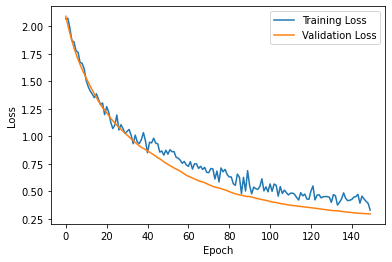

Best validation accuracy: 0.9069767594337463
Training accuracy at the best test accuracy: 0.8166666626930237
Best validation accuracy: 0.9069767594337463
Training accuracy at the best test accuracy: 0.8166666626930237
Confusion matrix:
[[10  0  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0  0 16  0  1]
 [ 0  0  0  0  5  0]
 [ 0  0  0  3  0  3]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 84.21052631578947
Accuracy for 4 : 100.0
Accuracy for 5 : 75.0
Total Precision: 0.9320175438596491
Total Recall: 0.9068627450980392
Total F1 Score: 0.9148148148148149
Accuracy for each label: [100.         100.         100.          84.21052632 100.
  75.        ]
Precision for each label: [1.         1.         1.         0.84210526 1.         0.75      ]
Recall for each label: [1.         1.         1.         0.94117647 1.         0.5       ]
F1 Score for each label: [1.         1.         1.         0.88888889 1.         0.6       ]
Total Ac

In [15]:
run_model(ratio_2, callback_2)

/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
18/18 [==============================] - 1s 13ms/step - loss: 2.0452 - accuracy: 0.0870 - val_loss: 1.9158 - val_accuracy: 0.0000e+00
Epoch 2/150
18/18 [==============================] - 0s 3ms/step - loss: 1.7832 - accuracy: 0.1739 - val_loss: 1.8153 - val_accuracy: 0.0000e+00
Epoch 3/150
18/18 [==============================] - 0s 5ms/step - loss: 1.7955 - accuracy: 0.2174 - val_loss: 1.7311 - val_accuracy: 0.0294
Epoch 4/150
18/18 [==============================] - 0s 6ms/step - loss: 1.8194 - accuracy: 0.2609 - val_loss: 1.6536 - val_accuracy: 0.0882
Epoch 5/150
18/18 [==============================] - 0s 6ms/step - loss: 1.6326 - accuracy: 0.2899 - val_loss: 1.5806 - val_accuracy: 0.5588
Epoch 6/150
18/18 [==============================] - 0s 5ms/step - loss: 1.6577 - accuracy: 0.3623 - val_loss: 1.5152 - val_accuracy: 0.6176
Epoch 7/150
18/18 [==============================] - 0s 4ms/step - loss: 1.5927 - accuracy: 0.3623 - val_loss: 1.4623 - val_accuracy: 0.6176
Epoc

Epoch 59/150
18/18 [==============================] - 0s 4ms/step - loss: 0.8528 - accuracy: 0.7101 - val_loss: 0.6006 - val_accuracy: 0.7353
Epoch 60/150
18/18 [==============================] - 0s 21ms/step - loss: 0.7337 - accuracy: 0.7536 - val_loss: 0.5898 - val_accuracy: 0.7647
Epoch 61/150
18/18 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.7681 - val_loss: 0.5796 - val_accuracy: 0.7647
Epoch 62/150
18/18 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.7826 - val_loss: 0.5699 - val_accuracy: 0.7647
Epoch 63/150
18/18 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.7101 - val_loss: 0.5610 - val_accuracy: 0.7647
Epoch 64/150
18/18 [==============================] - 0s 4ms/step - loss: 0.6724 - accuracy: 0.7391 - val_loss: 0.5530 - val_accuracy: 0.7647
Epoch 65/150
18/18 [==============================] - 0s 5ms/step - loss: 0.6570 - accuracy: 0.7681 - val_loss: 0.5470 - val_accuracy: 0.8235
Epoch

18/18 [==============================] - 0s 4ms/step - loss: 0.5375 - accuracy: 0.8261 - val_loss: 0.3846 - val_accuracy: 0.9118
Epoch 117/150
18/18 [==============================] - 0s 4ms/step - loss: 0.4335 - accuracy: 0.7826 - val_loss: 0.3834 - val_accuracy: 0.9118
Epoch 118/150
18/18 [==============================] - 0s 4ms/step - loss: 0.4160 - accuracy: 0.8406 - val_loss: 0.3807 - val_accuracy: 0.9118
Epoch 119/150
18/18 [==============================] - 0s 3ms/step - loss: 0.4555 - accuracy: 0.8551 - val_loss: 0.3779 - val_accuracy: 0.9118
Epoch 120/150
18/18 [==============================] - 0s 3ms/step - loss: 0.4534 - accuracy: 0.7971 - val_loss: 0.3783 - val_accuracy: 0.9118
Epoch 121/150
18/18 [==============================] - 0s 3ms/step - loss: 0.4446 - accuracy: 0.8406 - val_loss: 0.3767 - val_accuracy: 0.9118
Epoch 122/150
18/18 [==============================] - 0s 3ms/step - loss: 0.4064 - accuracy: 0.8551 - val_loss: 0.3718 - val_accuracy: 0.9118
Epoch 123/150

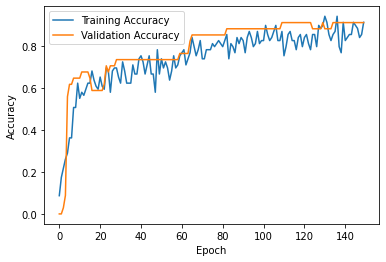

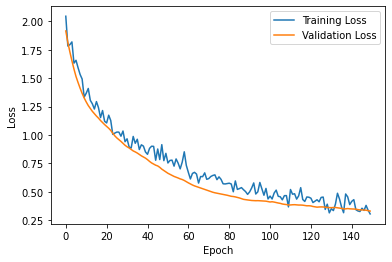

Best validation accuracy: 0.9117646813392639
Training accuracy at the best test accuracy: 0.8695651888847351
Best validation accuracy: 0.9117646813392639
Training accuracy at the best test accuracy: 0.8695651888847351
Confusion matrix:
[[ 7  0  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0  0 13  0  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  3  0  2]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 81.25
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.96875
Total Recall: 0.9
Total F1 Score: 0.9113300492610836
Accuracy for each label: [100.   100.   100.    81.25 100.   100.  ]
Precision for each label: [1.     1.     1.     0.8125 1.     1.    ]
Recall for each label: [1.  1.  1.  1.  1.  0.4]
F1 Score for each label: [1.         1.         1.         0.89655172 1.         0.57142857]
Total Accuracy: 91.17647058823529


In [16]:
run_model(ratio_3, callback_3)

/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
20/20 [==============================] - 1s 13ms/step - loss: 2.0511 - accuracy: 0.1250 - val_loss: 1.8156 - val_accuracy: 0.2609
Epoch 2/150
20/20 [==============================] - 0s 3ms/step - loss: 2.0101 - accuracy: 0.1750 - val_loss: 1.7359 - val_accuracy: 0.2609
Epoch 3/150
20/20 [==============================] - 0s 5ms/step - loss: 1.9123 - accuracy: 0.2000 - val_loss: 1.6609 - val_accuracy: 0.3478
Epoch 4/150
20/20 [==============================] - 0s 5ms/step - loss: 1.8782 - accuracy: 0.2250 - val_loss: 1.6006 - val_accuracy: 0.5652
Epoch 5/150
20/20 [==============================] - 0s 6ms/step - loss: 1.7745 - accuracy: 0.2750 - val_loss: 1.5429 - val_accuracy: 0.7826
Epoch 6/150
20/20 [==============================] - 0s 3ms/step - loss: 1.7548 - accuracy: 0.3750 - val_loss: 1.4912 - val_accuracy: 0.7826
Epoch 7/150
20/20 [==============================] - 0s 3ms/step - loss: 1.7266 - accuracy: 0.3875 - val_loss: 1.4416 - val_accuracy: 0.7826
Epoch 8/150


Epoch 59/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.7125 - val_loss: 0.4552 - val_accuracy: 0.8696
Epoch 60/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.7250 - val_loss: 0.4478 - val_accuracy: 0.8696
Epoch 61/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.8125 - val_loss: 0.4429 - val_accuracy: 0.8696
Epoch 62/150
20/20 [==============================] - 0s 3ms/step - loss: 0.5881 - accuracy: 0.7750 - val_loss: 0.4417 - val_accuracy: 0.8696
Epoch 63/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.8000 - val_loss: 0.4371 - val_accuracy: 0.8696
Epoch 64/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6042 - accuracy: 0.7500 - val_loss: 0.4305 - val_accuracy: 0.9130
Epoch 65/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.8000 - val_loss: 0.4204 - val_accuracy: 0.8696
Epoch 

20/20 [==============================] - 0s 3ms/step - loss: 0.3497 - accuracy: 0.8750 - val_loss: 0.2972 - val_accuracy: 0.9130
Epoch 117/150
20/20 [==============================] - 0s 3ms/step - loss: 0.3874 - accuracy: 0.8500 - val_loss: 0.2939 - val_accuracy: 0.9130
Epoch 118/150
20/20 [==============================] - 0s 3ms/step - loss: 0.4279 - accuracy: 0.8500 - val_loss: 0.2924 - val_accuracy: 0.9130
Epoch 119/150
20/20 [==============================] - 0s 3ms/step - loss: 0.4066 - accuracy: 0.8375 - val_loss: 0.2902 - val_accuracy: 0.9130
Epoch 120/150
20/20 [==============================] - 0s 3ms/step - loss: 0.3350 - accuracy: 0.9000 - val_loss: 0.2908 - val_accuracy: 0.9130
Epoch 121/150
20/20 [==============================] - 0s 3ms/step - loss: 0.3886 - accuracy: 0.8500 - val_loss: 0.2900 - val_accuracy: 0.9130
Epoch 122/150
20/20 [==============================] - 0s 3ms/step - loss: 0.3268 - accuracy: 0.8625 - val_loss: 0.2895 - val_accuracy: 0.9130
Epoch 123/150

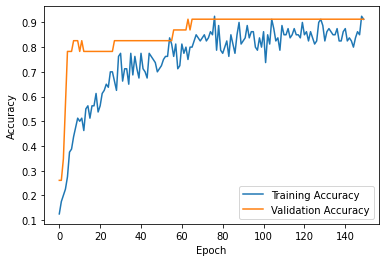

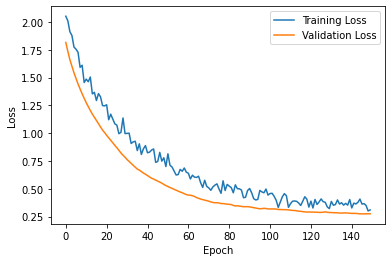

Best validation accuracy: 0.9130434989929199
Training accuracy at the best test accuracy: 0.75
Best validation accuracy: 0.9130434989929199
Training accuracy at the best test accuracy: 0.75
Confusion matrix:
[[5 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 3 0]
 [0 0 0 2 0 1]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 81.81818181818183
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.9696969696969697
Total Recall: 0.8888888888888888
Total F1 Score: 0.9
Accuracy for each label: [100.         100.         100.          81.81818182 100.
 100.        ]
Precision for each label: [1.         1.         1.         0.81818182 1.         1.        ]
Recall for each label: [1.         1.         1.         1.         1.         0.33333333]
F1 Score for each label: [1.  1.  1.  0.9 1.  0.5]
Total Accuracy: 91.30434782608695


In [17]:
run_model(ratio_4, callback_4)

/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_545838/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_545838/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/150
23/23 [==============================] - 1s 10ms/step - loss: 1.8793 - accuracy: 0.3034 - val_loss: 1.5684 - val_accuracy: 0.4286
Epoch 2/150
23/23 [==============================] - 0s 4ms/step - loss: 1.7278 - accuracy: 0.2921 - val_loss: 1.4857 - val_accuracy: 0.5714
Epoch 3/150
23/23 [==============================] - 0s 4ms/step - loss: 1.6762 - accuracy: 0.4831 - val_loss: 1.4128 - val_accuracy: 0.6429
Epoch 4/150
23/23 [==============================] - 0s 3ms/step - loss: 1.5204 - accuracy: 0.4382 - val_loss: 1.3504 - val_accuracy: 0.6429
Epoch 5/150
23/23 [==============================] - 0s 3ms/step - loss: 1.6509 - accuracy: 0.4831 - val_loss: 1.2913 - val_accuracy: 0.6429
Epoch 6/150
23/23 [==============================] - 0s 3ms/step - loss: 1.4482 - accuracy: 0.5506 - val_loss: 1.2388 - val_accuracy: 0.6429
Epoch 7/150
23/23 [==============================] - 0s 3ms/step - loss: 1.4085 - accuracy: 0.4607 - val_loss: 1.1859 - val_accuracy: 0.6429
Epoch 8/150


Epoch 59/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.7640 - val_loss: 0.4369 - val_accuracy: 0.9286
Epoch 60/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.7865 - val_loss: 0.4302 - val_accuracy: 0.9286
Epoch 61/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.8315 - val_loss: 0.4242 - val_accuracy: 0.9286
Epoch 62/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5280 - accuracy: 0.8427 - val_loss: 0.4228 - val_accuracy: 0.9286
Epoch 63/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5148 - accuracy: 0.7865 - val_loss: 0.4193 - val_accuracy: 0.9286
Epoch 64/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5189 - accuracy: 0.8315 - val_loss: 0.4108 - val_accuracy: 0.9286
Epoch 65/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6085 - accuracy: 0.7978 - val_loss: 0.4082 - val_accuracy: 0.9286
Epoch 

23/23 [==============================] - 0s 3ms/step - loss: 0.4066 - accuracy: 0.7978 - val_loss: 0.3025 - val_accuracy: 0.9286
Epoch 117/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4162 - accuracy: 0.8539 - val_loss: 0.3025 - val_accuracy: 0.9286
Epoch 118/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3642 - accuracy: 0.8652 - val_loss: 0.3019 - val_accuracy: 0.9286
Epoch 119/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3735 - accuracy: 0.8427 - val_loss: 0.2988 - val_accuracy: 0.9286
Epoch 120/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3302 - accuracy: 0.8989 - val_loss: 0.2921 - val_accuracy: 0.9286
Epoch 121/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3384 - accuracy: 0.8652 - val_loss: 0.2908 - val_accuracy: 0.9286
Epoch 122/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4105 - accuracy: 0.7865 - val_loss: 0.2924 - val_accuracy: 0.9286
Epoch 123/150

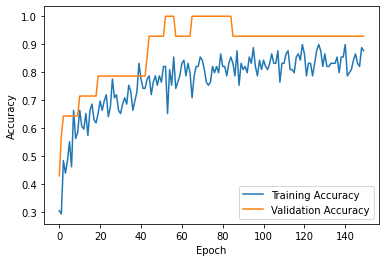

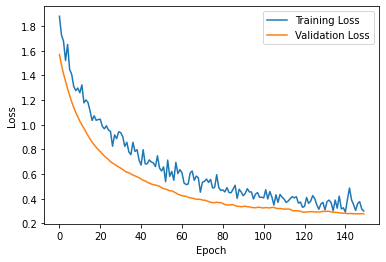

Best validation accuracy: 1.0
Training accuracy at the best test accuracy: 0.8202247023582458
Best validation accuracy: 1.0
Training accuracy at the best test accuracy: 0.8202247023582458
Confusion matrix:
[[3 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 2 0]
 [0 0 0 1 0 1]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 83.33333333333334
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.9722222222222223
Total Recall: 0.9166666666666666
Total F1 Score: 0.9292929292929294
Accuracy for each label: [100.         100.         100.          83.33333333 100.
 100.        ]
Precision for each label: [1.         1.         1.         0.83333333 1.         1.        ]
Recall for each label: [1.  1.  1.  1.  1.  0.5]
F1 Score for each label: [1.         1.         1.         0.90909091 1.         0.66666667]
Total Accuracy: 92.85714285714286


In [18]:
run_model(ratio_5, callback_5)

# 

# N